# 1. Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Mini Project/buoys_data.csv')

# Data Cleaning
# Handle missing values (like -99.9 in Peak Direction)
data.replace(-99.9, np.nan, inplace=True)

# Convert date/time to datetime object and extract features
data['Date/Time (AEST)'] = pd.to_datetime(data['Date/Time (AEST)'])
data['hour'] = data['Date/Time (AEST)'].dt.hour
data['day'] = data['Date/Time (AEST)'].dt.day
data['month'] = data['Date/Time (AEST)'].dt.month

# Drop original datetime column and ID
data.drop(['_id', 'Date/Time (AEST)'], axis=1, inplace=True)

# Handle missing values
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Feature Engineering
# Create rolling features for time series data
window_size = 6  # 3 hours window (30-min intervals)
for col in ['Hs (m)', 'Hmax (m)', 'Tz (s)', 'Tp (s)', 'Peak Direction (degrees)', 'SST (degrees C)']:
    data_imputed[f'{col}_rolling_mean'] = data_imputed[col].rolling(window=window_size).mean()
    data_imputed[f'{col}_rolling_std'] = data_imputed[col].rolling(window=window_size).std()

# Drop rows with NaN values from rolling features
data_imputed.dropna(inplace=True)

# Define target variables (predicting next time step)
target_cols = ['Hs (m)', 'Hmax (m)', 'Tz (s)', 'Tp (s)']
for col in target_cols:
    data_imputed[f'next_{col}'] = data_imputed[col].shift(-1)

# Drop the last row which will have NaN for target
data_imputed.dropna(inplace=True)

# Separate features and targets
X = data_imputed.drop([f'next_{col}' for col in target_cols], axis=1)
y = data_imputed[[f'next_{col}' for col in target_cols]]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save processed data for later use
import joblib
joblib.dump(scaler, 'scaler.pkl')
data_imputed.to_csv('processed_buoy_data.csv', index=False)

# 2. Data Visualization

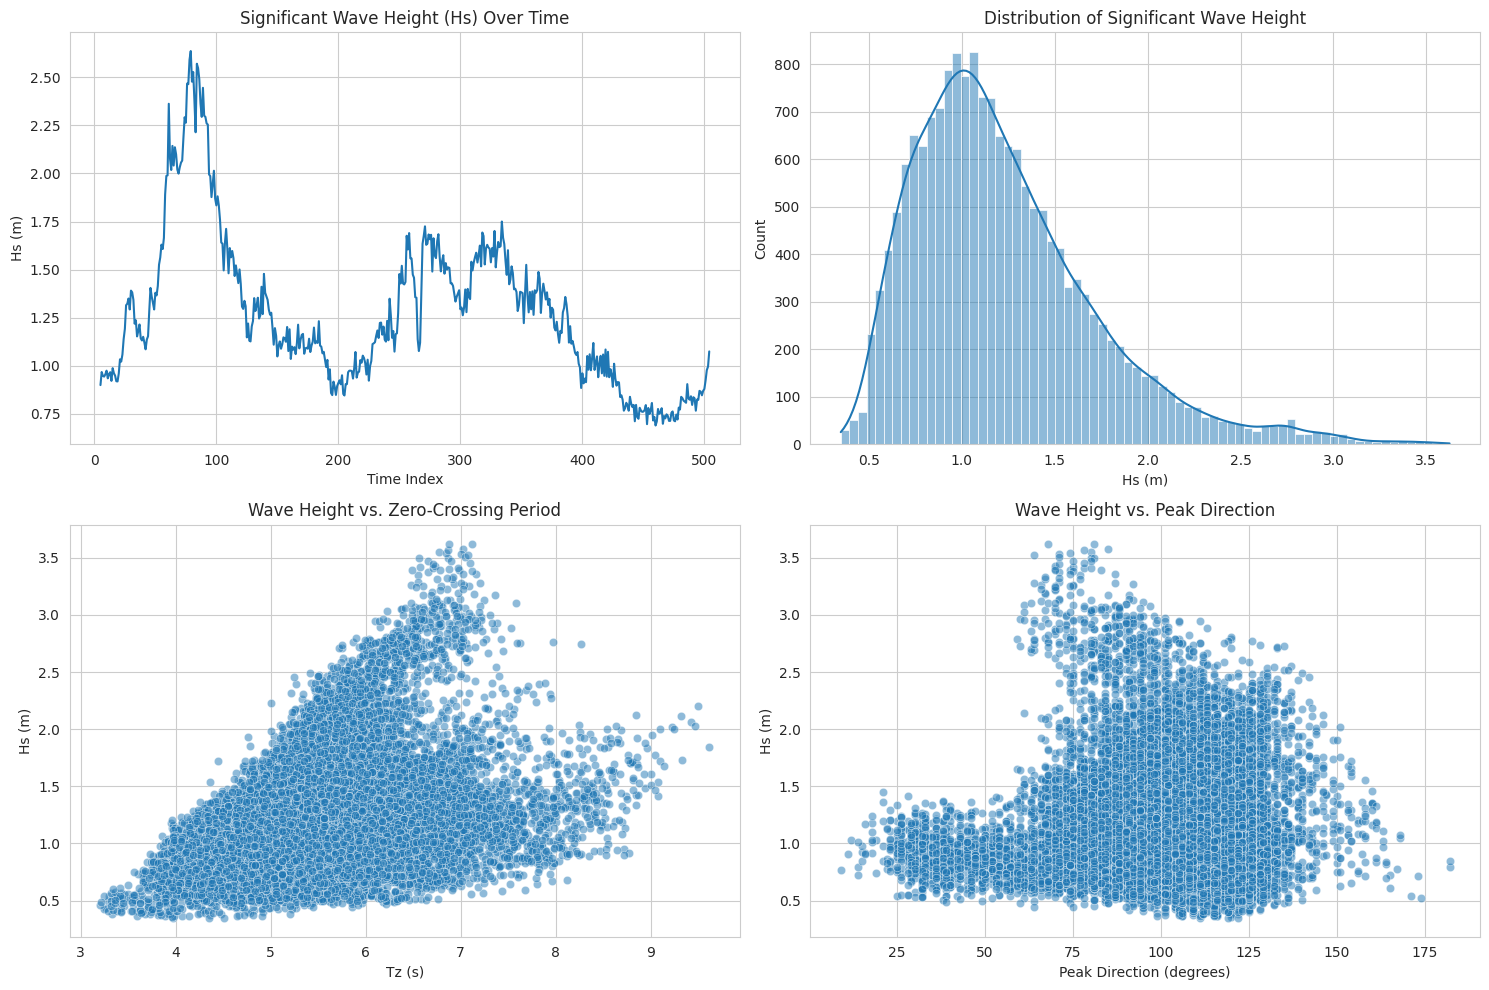

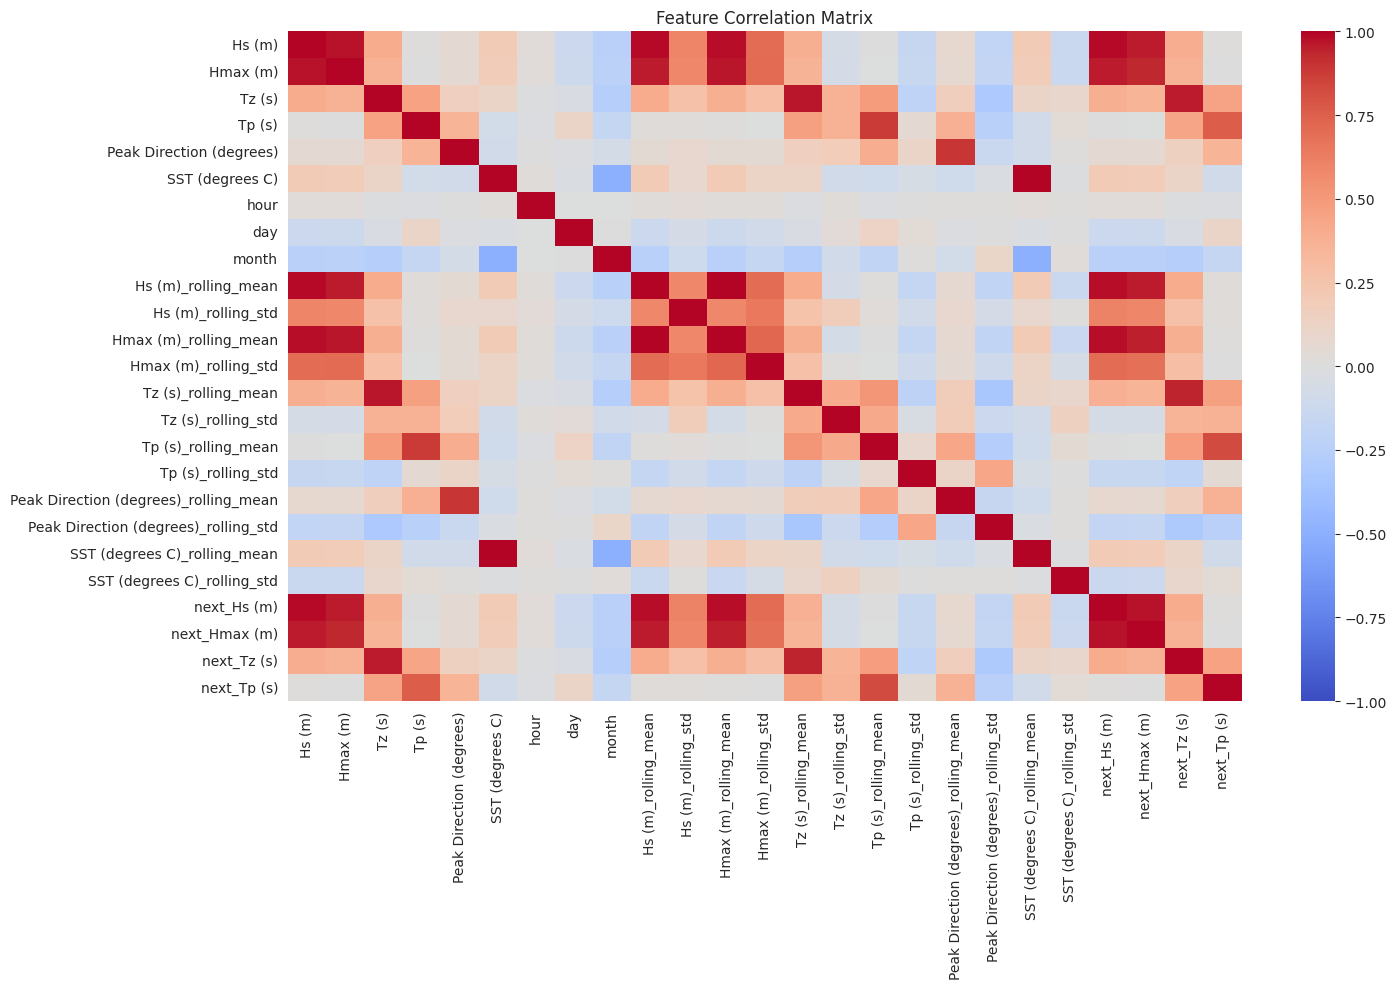

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.figure(figsize=(15, 10))

# Time series of significant wave height
plt.subplot(2, 2, 1)
plt.plot(data_imputed.index[:500], data_imputed['Hs (m)'][:500])
plt.title('Significant Wave Height (Hs) Over Time')
plt.xlabel('Time Index')
plt.ylabel('Hs (m)')

# Distribution of wave heights
plt.subplot(2, 2, 2)
sns.histplot(data_imputed['Hs (m)'], kde=True)
plt.title('Distribution of Significant Wave Height')
plt.xlabel('Hs (m)')

# Wave period relationship
plt.subplot(2, 2, 3)
sns.scatterplot(x='Tz (s)', y='Hs (m)', data=data_imputed, alpha=0.5)
plt.title('Wave Height vs. Zero-Crossing Period')
plt.xlabel('Tz (s)')
plt.ylabel('Hs (m)')

# Directional distribution
plt.subplot(2, 2, 4)
sns.scatterplot(x='Peak Direction (degrees)', y='Hs (m)', data=data_imputed, alpha=0.5)
plt.title('Wave Height vs. Peak Direction')
plt.xlabel('Peak Direction (degrees)')
plt.ylabel('Hs (m)')

plt.tight_layout()
plt.show()

# Correlation matrix
corr_matrix = data_imputed.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 3. Model Building

3.1 Random Forest Regressor

Random Forest Evaluation:
Mean Squared Error: 0.4814
Mean Absolute Error: 0.3369
R-squared: 0.8604


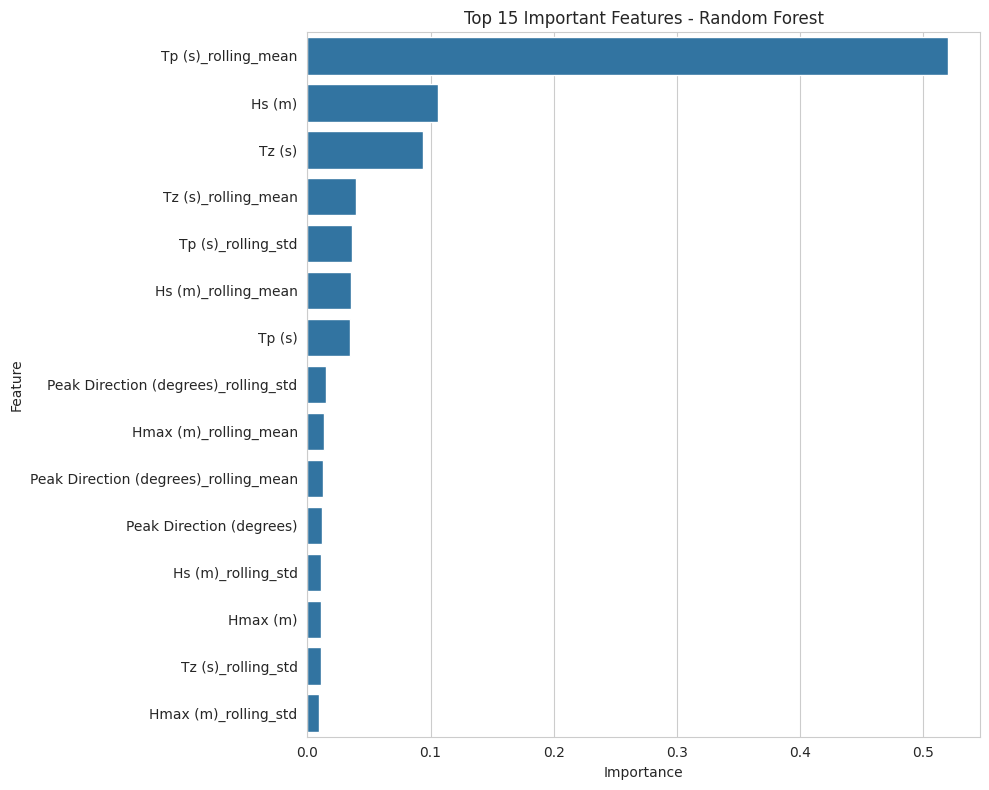

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize model
rf = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1)

# Train model
rf.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf.predict(X_test_scaled)

# Evaluation
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Evaluation:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")

    return mse, mae, r2

rf_mse, rf_mae, rf_r2 = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Important Features - Random Forest')
plt.tight_layout()
plt.show()

# Save model
#joblib.dump(rf, 'random_forest_model.pkl')

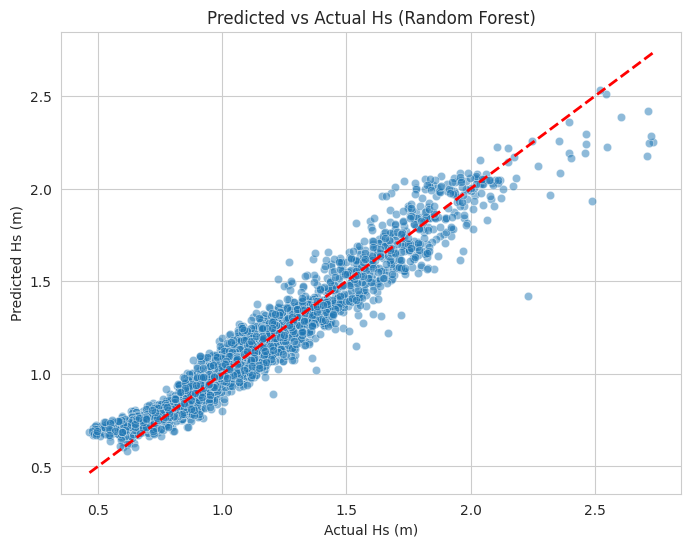

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have y_test (actual values) and y_pred_rf (predicted values)
# from your Random Forest model training

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.scatterplot(x=y_test['next_Hs (m)'], y=y_pred_rf[:, 0], alpha=0.5)
# Assuming 'next_Hs (m)' is the target column in y_test

plt.title('Predicted vs Actual Hs (Random Forest)')
plt.xlabel('Actual Hs (m)')
plt.ylabel('Predicted Hs (m)')

# Add a diagonal line for reference (perfect predictions)
plt.plot([y_test['next_Hs (m)'].min(), y_test['next_Hs (m)'].max()],
         [y_test['next_Hs (m)'].min(), y_test['next_Hs (m)'].max()],
         linestyle='--', color='red', linewidth=2)

plt.grid(True)
plt.show()

3.2 Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize model
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)

# Train model
#gbr.fit(X_train_scaled, y_train)
gbr.fit(X_train_scaled, y_train['next_Hs (m)'])  # Choose one target column, for example 'next_Hs (m)'


# Predictions
y_pred_gbr = gbr.predict(X_test_scaled)

# Evaluation
# Select the corresponding column from y_test for evaluation
gbr_mse, gbr_mae, gbr_r2 = evaluate_model(y_test['next_Hs (m)'], y_pred_gbr, "Gradient Boosting")

# Save model
joblib.dump(gbr, 'gradient_boosting_model.pkl')

Gradient Boosting Evaluation:
Mean Squared Error: 0.0043
Mean Absolute Error: 0.0483
R-squared: 0.9681


['gradient_boosting_model.pkl']

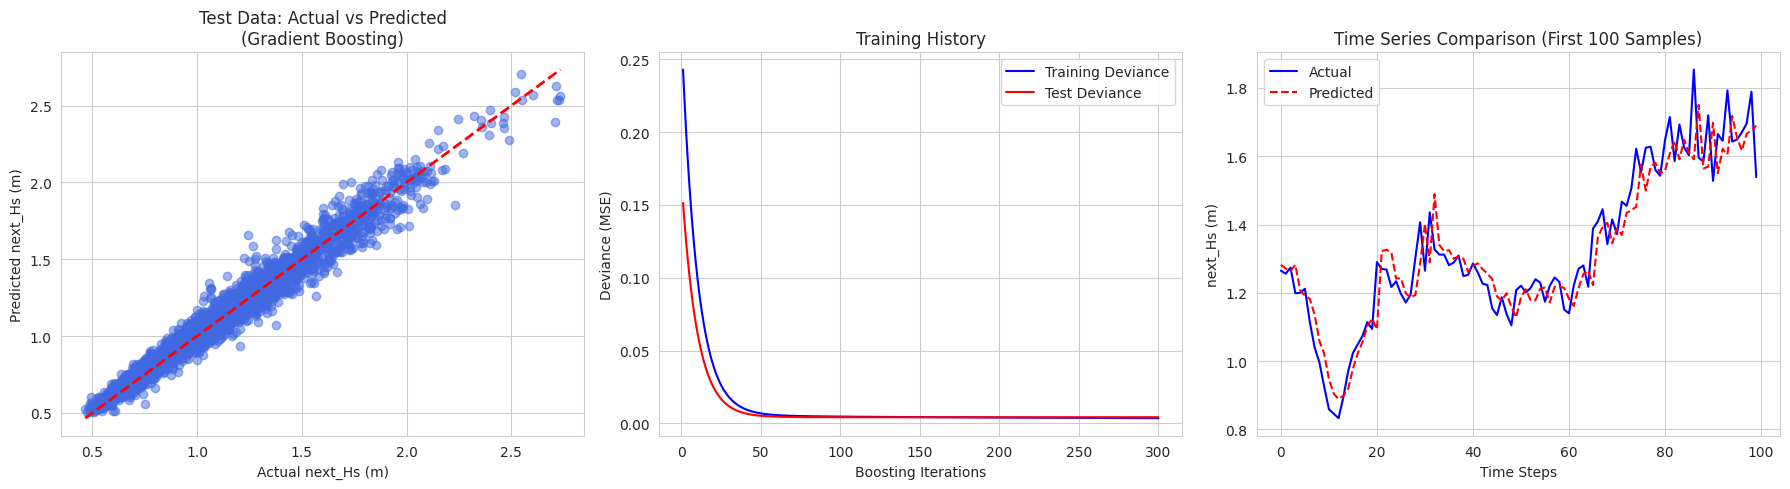

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Initialize and train model (as in your code)
gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                               max_depth=5, random_state=42)
gbr.fit(X_train_scaled, y_train['next_Hs (m)'])

# Predictions
y_train_pred = gbr.predict(X_train_scaled)  # Predictions on training data
y_test_pred = gbr.predict(X_test_scaled)    # Predictions on test data

# Create figure with 3 subplots
plt.figure(figsize=(18, 5))

# --- Plot 1: Actual vs Predicted (Test Data) ---
plt.subplot(1, 3, 1)
plt.scatter(y_test['next_Hs (m)'], y_test_pred, alpha=0.5, color='royalblue')
plt.plot([min(y_test['next_Hs (m)']), max(y_test['next_Hs (m)'])],
         [min(y_test['next_Hs (m)']), max(y_test['next_Hs (m)'])],
         '--r', linewidth=2)
plt.xlabel('Actual next_Hs (m)')
plt.ylabel('Predicted next_Hs (m)')
plt.title('Test Data: Actual vs Predicted\n(Gradient Boosting)')
plt.grid(True)

# --- Plot 2: Training Deviance (Learning Curve) ---
plt.subplot(1, 3, 2)
test_score = np.zeros(300, dtype=np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test_scaled)):
    # Calculate MSE manually using mean_squared_error
    test_score[i] = mean_squared_error(y_test['next_Hs (m)'], y_pred)

plt.plot(np.arange(300) + 1, gbr.train_score_, 'b-', label='Training Deviance')
plt.plot(np.arange(300) + 1, test_score, 'r-', label='Test Deviance')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance (MSE)')
plt.title('Training History')
plt.legend(loc='upper right')
plt.grid(True)

# --- Plot 3: Time Series Comparison (First 100 samples) ---
plt.subplot(1, 3, 3)
plt.plot(y_test['next_Hs (m)'].values[:100], 'b-', label='Actual')
plt.plot(y_test_pred[:100], 'r--', label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('next_Hs (m)')
plt.title('Time Series Comparison (First 100 Samples)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

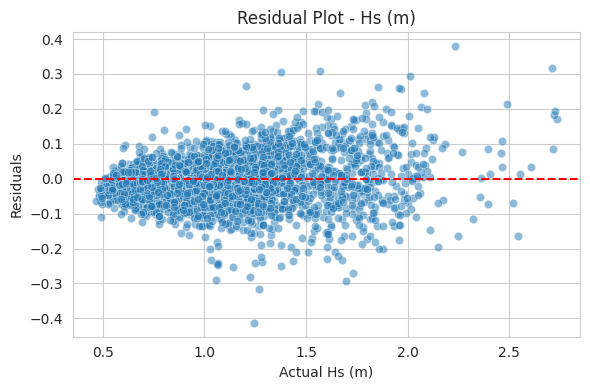

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have y_test (actual values) and y_pred_gbr (predicted values)
# from your Gradient Boosting model training

# Calculate residuals for 'next_Hs (m)' (only one target predicted)
residuals_Hs = y_test['next_Hs (m)'] - y_pred_gbr

# Create the residual plot
plt.figure(figsize=(6, 4))  # Adjusted figure size

plt.subplot(1, 1, 1)  # Only one subplot needed
sns.scatterplot(x=y_test['next_Hs (m)'], y=residuals_Hs, alpha=0.5)
plt.title('Residual Plot - Hs (m)')
plt.xlabel('Actual Hs (m)')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

3.3 Long Short-Term Memory (LSTM) Neural Network

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 6.4801 - mae: 1.4554 - val_loss: 1.0068 - val_mae: 0.5213
Epoch 2/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.7200 - mae: 0.5171 - val_loss: 0.9495 - val_mae: 0.4692
Epoch 3/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.7339 - mae: 0.4953 - val_loss: 0.9914 - val_mae: 0.5090
Epoch 4/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - loss: 0.6978 - mae: 0.4790 - val_loss: 0.9054 - val_mae: 0.4328
Epoch 5/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.6682 - mae: 0.4614 - val_loss: 0.9112 - val_mae: 0.4445
Epoch 6/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.6216 - mae: 0.4425 - val_loss: 0.9501 - val_mae: 0.4733
Epoch 7/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.6220 - mae: 0.4437 - val_loss: 0.9644 - val_mae: 0.4598
Epoch 8/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - loss: 0.5739 - mae: 0.4253 - val_loss: 0.9574 - val_mae: 0.4798
Epoch 9/20
395/395 ━━━━━━━━━━━━━━━━━━━━ 

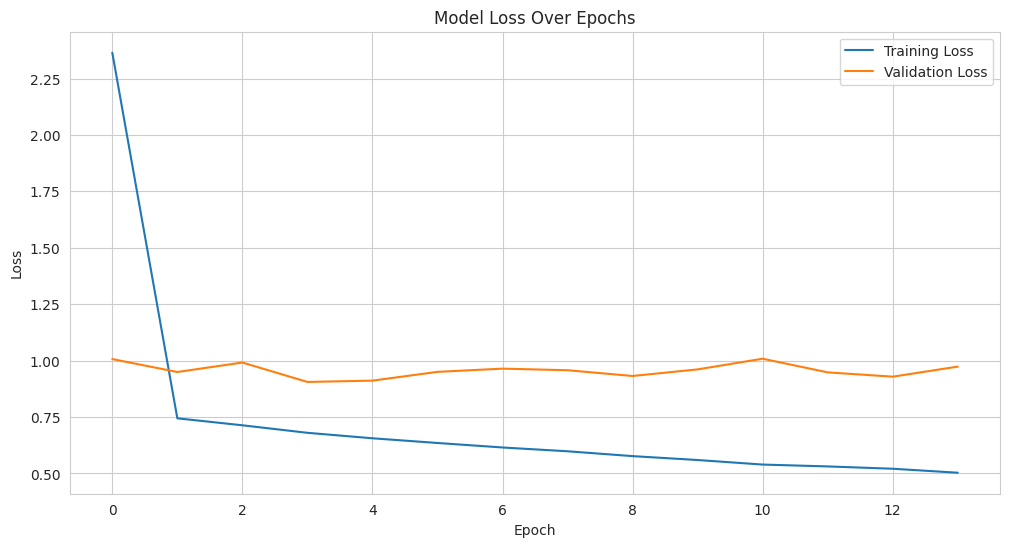

110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
LSTM Evaluation:
Mean Squared Error: 1.4421
Mean Absolute Error: 0.5751
R-squared: 0.2821


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Reshape data for LSTM (samples, timesteps, features)
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12  # 6 hours of data (30-min intervals)
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, time_steps)

# Build LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(y_train_seq.shape[1])
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions
y_pred_lstm = model.predict(X_test_seq)

# Evaluation
lstm_mse, lstm_mae, lstm_r2 = evaluate_model(y_test[time_steps:], y_pred_lstm, "LSTM")

# Save model
#model.save('lstm_model.h5')

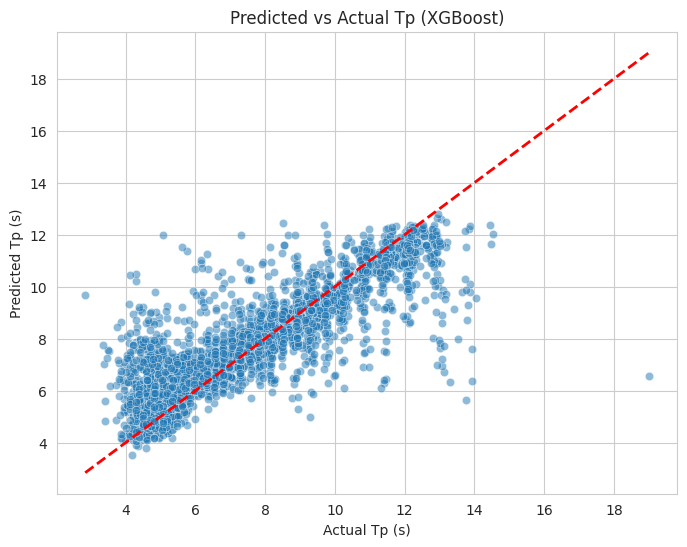

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have y_test (actual values) and y_pred_xgb (predicted values)
# from your XGBoost model training

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.scatterplot(x=y_test['next_Tp (s)'], y=y_pred_xgb[:, 3], alpha=0.5)
# Assuming 'next_Tp (s)' is the target column in y_test and it's the 4th column in y_pred_xgb

plt.title('Predicted vs Actual Tp (XGBoost)')
plt.xlabel('Actual Tp (s)')
plt.ylabel('Predicted Tp (s)')

# Add a diagonal line for reference (perfect predictions)
plt.plot([y_test['next_Tp (s)'].min(), y_test['next_Tp (s)'].max()],
         [y_test['next_Tp (s)'].min(), y_test['next_Tp (s)'].max()],
         linestyle='--', color='red', linewidth=2)

plt.grid(True)
plt.show()

3.4 XGBoost Regressor

In [ ]:
import xgboost as xgb

# Initialize model
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

# Train model
xgb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluation
xgb_mse, xgb_mae, xgb_r2 = evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Save model
#joblib.dump(xgb_model, 'xgboost_model.pkl')

XGBoost Evaluation:
Mean Squared Error: 0.4510
Mean Absolute Error: 0.3061
R-squared: 0.8797


Text(0, 0.5, 'Predicted Tp (s)')

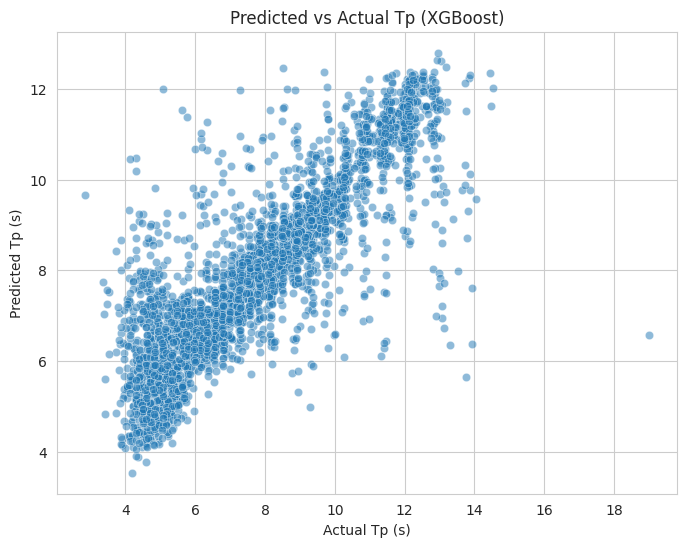

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have y_test (actual values) and y_pred_xgb (predicted values)
# from your XGBoost model training

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.scatterplot(x=y_test['next_Tp (s)'], y=y_pred_xgb[:, 3], alpha=0.5)
# Assuming 'next_Tp (s)' is the target column in y_test and it's the 4th column in y_pred_xgb

plt.title('Predicted vs Actual Tp (XGBoost)')
plt.xlabel('Actual Tp (s)')
plt.ylabel('Predicted Tp (s)')

# Add a diagonal line for reference (perfect predictions

# 4. Model Comparison


Model Comparison:
               Model       MSE       MAE        R2
0      Random Forest  0.481351  0.336855  0.860358
1  Gradient Boosting  0.004305  0.048278  0.968091
2               LSTM  0.504055  0.381042  0.810145
3            XGBoost  0.450966  0.306054  0.879669


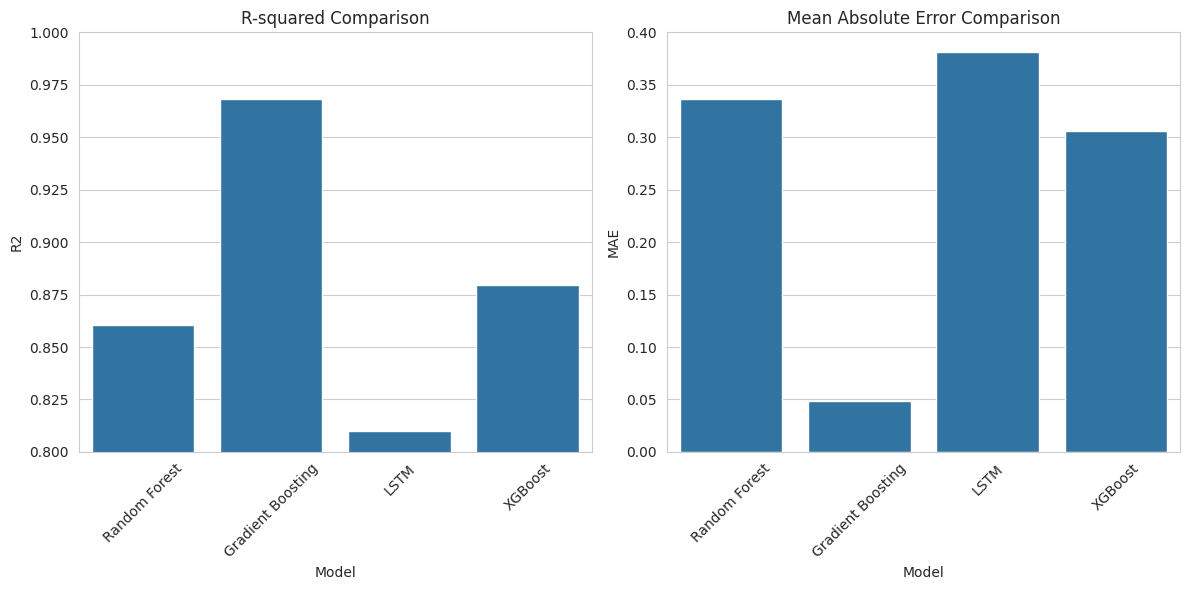

In [ ]:
# Compare model performance
models = ['Random Forest', 'Gradient Boosting', 'LSTM', 'XGBoost']
mse_scores = [rf_mse, gbr_mse, lstm_mse, xgb_mse]
mae_scores = [rf_mae, gbr_mae, lstm_mae, xgb_mae]
r2_scores = [rf_r2, gbr_r2, lstm_r2, xgb_r2]

results_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'MAE': mae_scores,
    'R2': r2_scores
})

print("\nModel Comparison:")
print(results_df)

# Plot comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='R2', data=results_df)
plt.title('R-squared Comparison')
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='MAE', data=results_df)
plt.title('Mean Absolute Error Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# Lists to store model names and scores
models = ['Random Forest', 'Gradient Boosting', 'LSTM', 'XGBoost']
mse_scores = []
mae_scores = []
r2_scores = []

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluates the model and appends scores to the global lists.

    Args:
        y_true: The true target values.
        y_pred: The predicted target values.
        model_name: The name of the model being evaluated.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Append scores to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"{model_name} Evaluation:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R-squared: {r2:.4f}")

    return mse, mae, r2

# Call evaluate_model for each model, ensuring consistent data shapes:
rf_mse, rf_mae, rf_r2 = evaluate_model(y_test, y_pred_rf, "Random Forest")

# For Gradient Boosting, if trained on a single target:
gbr_mse, gbr_mae, gbr_r2 = evaluate_model(y_test[['next_Hs (m)']], y_pred_gbr.reshape(-1, 1), "Gradient Boosting")
# If trained on multiple targets, adjust accordingly

# For LSTM, adjust y_test based on time_steps and target columns used during training:
lstm_mse, lstm_mae, lstm_r2 = evaluate_model(y_test[time_steps:][['next_Hs (m)', 'next_Hmax (m)', 'next_Tz (s)', 'next_Tp (s)']], y_pred_lstm, "LSTM")
# Adjust target columns if needed

xgb_mse, xgb_mae, xgb_r2 = evaluate_model(y_test, y_pred_xgb, "XGBoost")


# 3. Model Comparison with Tabulate

# Create the results DataFrame
results_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_scores,
    'MAE': mae_scores,
    'R2': r2_scores
})

# Display the table using tabulate
print("\nModel Comparison:")
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid'))


Random Forest Evaluation:
Mean Squared Error: 0.4814
Mean Absolute Error: 0.3369
R-squared: 0.8604
Gradient Boosting Evaluation:
Mean Squared Error: 0.0043
Mean Absolute Error: 0.0483
R-squared: 0.9681
LSTM Evaluation:
Mean Squared Error: 1.4421
Mean Absolute Error: 0.5751
R-squared: 0.2821
XGBoost Evaluation:
Mean Squared Error: 0.4510
Mean Absolute Error: 0.3061
R-squared: 0.8797

Model Comparison:
╒════╤═══════════════════╤════════════╤═══════════╤══════════╕
│    │ Model             │        MSE │       MAE │       R2 │
╞════╪═══════════════════╪════════════╪═══════════╪══════════╡
│  0 │ Random Forest     │ 0.481351   │ 0.336855  │ 0.860358 │
├────┼───────────────────┼────────────┼───────────┼──────────┤
│  1 │ Gradient Boosting │ 0.00430528 │ 0.0482777 │ 0.968091 │
├────┼───────────────────┼────────────┼───────────┼──────────┤
│  2 │ LSTM              │ 1.44215    │ 0.575111  │ 0.28209  │
├────┼───────────────────┼────────────┼───────────┼──────────┤
│  3 │ XGBoost           │ 0.

# 5. Model Deployment


Predicted Wave Conditions:
 predicted_Hs (m)
         1.188596


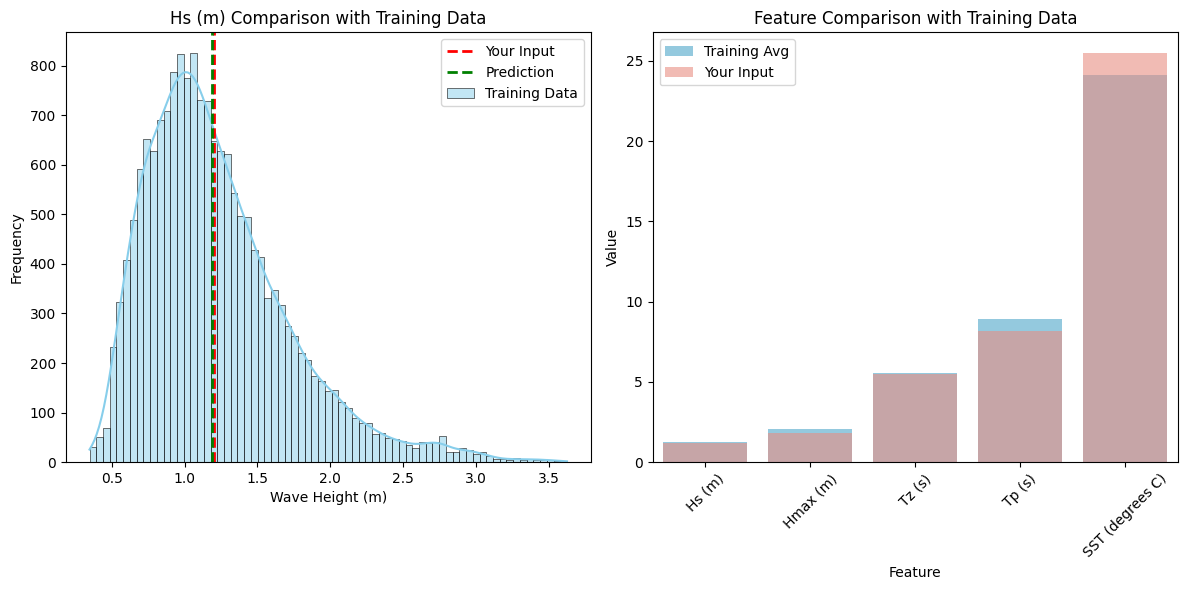

In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load model, scaler, and your training data (assuming you have it)
best_model = joblib.load('gradient_boosting_model.pkl')
scaler = joblib.load('scaler.pkl')
train_data = pd.read_csv('processed_buoy_data.csv')  # Replace with your actual training data file

def predict_wave_conditions(new_data):
    """Predict wave conditions for new data"""
    new_data_processed = new_data.copy()

    # Add rolling features
    window_size = 6
    for col in ['Hs (m)', 'Hmax (m)', 'Tz (s)', 'Tp (s)', 'Peak Direction (degrees)', 'SST (degrees C)']:
        new_data_processed[f'{col}_rolling_mean'] = new_data_processed[col].rolling(window=window_size, min_periods=1).mean()
        new_data_processed[f'{col}_rolling_std'] = new_data_processed[col].rolling(window=window_size, min_periods=1).std()

    new_data_processed.fillna(0, inplace=True)
    new_data_scaled = scaler.transform(new_data_processed)
    prediction = best_model.predict(new_data_scaled)

    return pd.DataFrame(prediction, columns=['predicted_Hs (m)'])

# Your custom input data
your_wave_data = pd.DataFrame({
    'Hs (m)': [1.2],
    'Hmax (m)': [1.8],
    'Tz (s)': [5.5],
    'Tp (s)': [8.2],
    'Peak Direction (degrees)': [90],
    'SST (degrees C)': [25.5],
    'hour': [12],
    'day': [15],
    'month': [1]
})

# Get predictions
results = predict_wave_conditions(your_wave_data)
print("\nPredicted Wave Conditions:")
print(results.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 6))

# Plot 1: Compare input Hs with training data distribution
plt.subplot(1, 2, 1)
sns.histplot(train_data['Hs (m)'], kde=True, color='skyblue', label='Training Data')
plt.axvline(your_wave_data['Hs (m)'].values[0], color='red', linestyle='--', linewidth=2, label='Your Input')
plt.axvline(results['predicted_Hs (m)'].values[0], color='green', linestyle='--', linewidth=2, label='Prediction')
plt.title('Hs (m) Comparison with Training Data')
plt.xlabel('Wave Height (m)')
plt.ylabel('Frequency')
plt.legend()

# Plot 2: Compare all input features
plt.subplot(1, 2, 2)
features = ['Hs (m)', 'Hmax (m)', 'Tz (s)', 'Tp (s)', 'SST (degrees C)']
train_means = train_data[features].mean()
your_data = your_wave_data[features].iloc[0]

comparison_df = pd.DataFrame({
    'Feature': features,
    'Training Mean': train_means,
    'Your Input': your_data
})

sns.barplot(x='Feature', y='Training Mean', data=comparison_df, color='skyblue', label='Training Avg')
sns.barplot(x='Feature', y='Your Input', data=comparison_df, color='salmon', alpha=0.6, label='Your Input')
plt.title('Feature Comparison with Training Data')
plt.xticks(rotation=45)
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()


Predicted Wave Conditions:
 next_Hs (m)  next_Tz (s)  next_Tp (s)
    1.731218     8.408751    15.342666


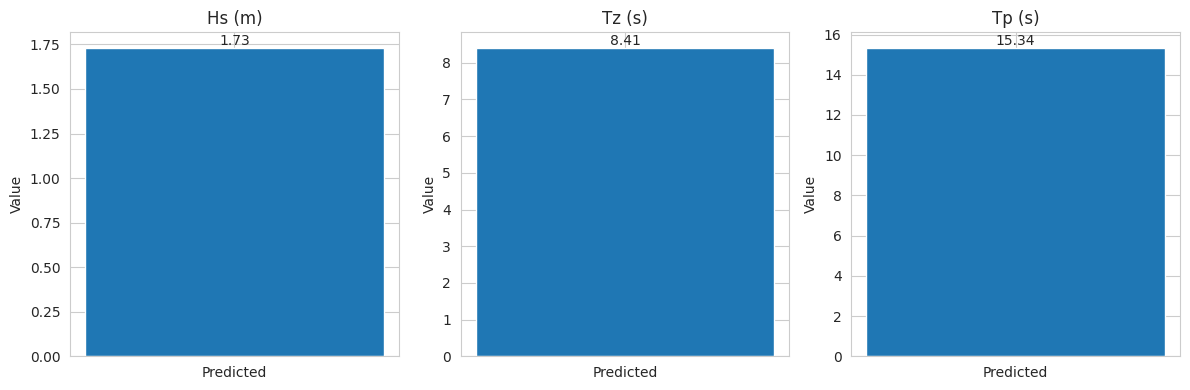

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import joblib

scaler = None # If no scaler
best_model = MultiOutputRegressor(
    GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
)

# Fit the model with your training data
best_model.fit(X_train_scaled, y_train[['next_Hs (m)', 'next_Tz (s)', 'next_Tp (s)']])

def predict_wave_conditions(new_data, target_columns=['next_Hs (m)', 'next_Tz (s)', 'next_Tp (s)']):
    """Predict multiple wave parameters"""
    new_data_processed = new_data.copy()

    # Feature engineering
    window_size = 6
    for col in ['Hs (m)', 'Hmax (m)', 'Tz (s)', 'Tp (s)', 'Peak Direction (degrees)', 'SST (degrees C)']:
        new_data_processed[f'{col}_rolling_mean'] = new_data_processed[col].rolling(window=window_size, min_periods=1).mean()
        new_data_processed[f'{col}_rolling_std'] = new_data_processed[col].rolling(window=window_size, min_periods=1).std()

    new_data_processed.fillna(0, inplace=True)
    # Apply scaler transform if scaler is loaded
    new_data_scaled = scaler.transform(new_data_processed) if scaler else new_data_processed.values

    # Predict all targets
    predictions = best_model.predict(new_data_scaled)
    return pd.DataFrame(predictions, columns=target_columns)

# Your input data
your_wave_data = pd.DataFrame({
    'Hs (m)': [1.2],
    'Hmax (m)': [1.8],
    'Tz (s)': [5.5],
    'Tp (s)': [8.2],
    'Peak Direction (degrees)': [90],
    'SST (degrees C)': [25.5],
    'hour': [12],
    'day': [15],
    'month': [1]
})

# Get predictions
results = predict_wave_conditions(your_wave_data)
print("\nPredicted Wave Conditions:")
print(results.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 4))
for i, col in enumerate(results.columns):
    plt.subplot(1, len(results.columns), i+1)
    plt.bar(['Predicted'], results[col].values[0])  # No change here
    plt.title(col.replace('next_', ''))
    plt.ylabel('Value')

    # Change here: Access the value directly
    v = results[col].values[0]
    plt.text(0, v, f"{v:.2f}", ha='center', va='bottom')  # Use 0 for x-position

plt.tight_layout()
plt.show()

#6. Install Gradio

In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 122.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.2 MB/s eta 0:00:00


#7. Loading the Model

In [3]:
import joblib
best_model = joblib.load('gradient_boosting_model.pkl')
scaler = joblib.load('scaler.pkl')

#8. Define the Pediction Function

In [7]:
def predict_wave(Hs, Hmax, Tz, Tp, direction, SST, hour, day, month):
    input_df = pd.DataFrame([{
        'Hs (m)': Hs,
        'Hmax (m)': Hmax,
        'Tz (s)': Tz,
        'Tp (s)': Tp,
        'Peak Direction (degrees)': direction,
        'SST (degrees C)': SST,
        'hour': hour,
        'day': day,
        'month': month
    }])

    # Add rolling features manually for a single input (fallback to actual value/std=0)
    for col in ['Hs (m)', 'Hmax (m)', 'Tz (s)', 'Tp (s)', 'Peak Direction (degrees)', 'SST (degrees C)']:
        input_df[f'{col}_rolling_mean'] = input_df[col]
        input_df[f'{col}_rolling_std'] = 0  # Setting std to 0 for single input

    input_scaled = scaler.transform(input_df)
    prediction = best_model.predict(input_scaled)[0]
    return prediction

def predict_wave_with_hist(Hs, Hmax, Tz, Tp, direction, SST, hour, day, month):
    prediction = predict_wave(Hs, Hmax, Tz, Tp, direction, SST, hour, day, month)

    # Create histogram
    fig, ax = plt.subplots()
    ax.hist([prediction], bins=10, color='skyblue', edgecolor='black')
    ax.set_title('Predicted Significant Wave Height (Hs)')
    ax.set_xlabel('Hs (m)')
    ax.set_ylabel('Frequency')
    ax.axvline(prediction, color='red', linestyle='--', linewidth=2, label='Prediction')
    ax.legend()

    # Convert plot to Gradio-compatible image
    hist_plot = gr.Plot(fig)

    return f"Predicted Significant Wave Height (Hs): {prediction:.2f} m", hist_plot

#9. Gradio Interface

In [8]:
iface = gr.Interface(
    fn=predict_wave_with_hist,  # Use the modified function
    inputs=[
        gr.Number(label="Hs (m)"),
        gr.Number(label="Hmax (m)"),
        gr.Number(label="Tz (s)"),
        gr.Number(label="Tp (s)"),
        gr.Number(label="Peak Direction (degrees)"),
        gr.Number(label="SST (degrees C)"),
        gr.Number(label="Hour"),
        gr.Number(label="Day"),
        gr.Number(label="Month"),
    ],
    outputs=["text", "plot"],
    title="🌊 Ocean Wave Predictor",
    description="Enter ocean wave and environmental data to predict significant wave height (Hs)."
)

iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://855edd01069662eb38.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
